In [1]:
import torch
import numpy as np
import math
import wandb
import matplotlib.pyplot as plt


from models.moe_layer.resnet.moe_block_layer import MoeBlockLayer
from models.moe_layer.resnet18.resnet18_experts import NarrowResNet18Expert
from models.moe_layer.resnet18.resnet18_moe import ResNet18MoE
from models.moe_layer.soft_gating_networks import SimpleGate
from models.moe_layer.hard_gating_networks import RelativeImportanceGate, AbsoluteImportanceGate
from models.moe_layer.static_gating_networks import EqualWeightGatingNetwork
from datasets.cifar100_dataset import CIFAR100Dataset
from utils.dataset_utils import train_test_split, get_transformation
from utils.cifar100_utils import CIFAR100_LABELS
from utils.visualize_activations import CNNActivationVisualization
from utils.visualize_features import CNNLayerVisualization

In [2]:
# Setting seeds
torch.manual_seed(42)
np.random.seed(42)

# Loading datasets
transformations_test = get_transformation('cifar100', phase='test')
basic_transformation = get_transformation('no_transform')
cifar_test = CIFAR100Dataset(
    root_dir='/home/lb4653/mixture-of-experts-thesis/data/cifar100/testing', transform=transformations_test)
cifar_test_no_prep = CIFAR100Dataset(
    root_dir='/home/lb4653/mixture-of-experts-thesis/data/cifar100/testing', transform=basic_transformation)

In [3]:
# Set model parameters
num_experts = 4
top_k = 2
loss_function = 'kl_divergence'
w_aux_loss = 0.5

# Load model
file_model = wandb.restore('ResNet18_kl_divergence_w=0.5_moePosition=0_final.tar', run_path='lukas-struppek/resnet18_moe/1vzsspq1')

# Create model
gate = SimpleGate(
    in_channels=3, 
    num_experts=num_experts,
    top_k=top_k,
    use_noise=True,
    name='SimpleGate_' + loss_function,
    loss_fkt=loss_function,
    w_aux_loss=w_aux_loss
    )
        
moe_layer = MoeBlockLayer(
    num_experts=num_experts, 
    layer_position=0, 
    top_k=top_k,
    gating_network=gate,
    resnet_expert=NarrowResNet18Expert)

model = ResNet18MoE(
    moe_layers=[moe_layer],
    name='ResNet18',
)

# Load parameters
model.load_state_dict(torch.load(file_model.name)['model_state_dict'])

# Move model to cuda
model = model.to(model.device)

# Reference to moe layer after loading parameters
moe_layer = model.input_layer

In [4]:
# Which samples result in largest weights
indices_list, weight_list = model.get_gating_weights(cifar_test, moe_layer, top_k=3)
print(indices_list)

[array([1927, 8041, 9691]), array([7735, 4956, 1838]), array([7521, 7316, 7307]), array([2022, 2307, 2801])]


In [5]:
# Review gating weights for different classes
df = model.mean_weights_per_class(moe_layer)

for expert in range(4):
    print(df.sort_values(by='expert ' + str(expert), ascending=False)[:5])
    print()

label  expert 0  expert 1  expert 2  expert 3
30   dolphin  0.494282  0.272278  0.027592  0.205848
73     shark  0.461211  0.365521  0.089870  0.083398
95     whale  0.453924  0.211412  0.004538  0.330126
49  mountain  0.453136  0.161304  0.024718  0.360842
52  oak_tree  0.447077  0.178076  0.058786  0.316061

            label  expert 0  expert 1  expert 2  expert 3
73          shark  0.461211  0.365521  0.089870  0.083398
1   aquarium_fish  0.241422  0.300329  0.334755  0.123494
30        dolphin  0.494282  0.272278  0.027592  0.205848
21     chimpanzee  0.312189  0.250501  0.200813  0.236496
67            ray  0.402691  0.241900  0.060699  0.294710

            label  expert 0  expert 1  expert 2  expert 3
62          poppy  0.161464  0.112428  0.349090  0.377019
1   aquarium_fish  0.241422  0.300329  0.334755  0.123494
18    caterpillar  0.204742  0.120825  0.330776  0.343657
82      sunflower  0.108512  0.074889  0.329754  0.486845
14      butterfly  0.227988  0.121157  0.326946  

In [14]:
# Define test image index
index = 8041

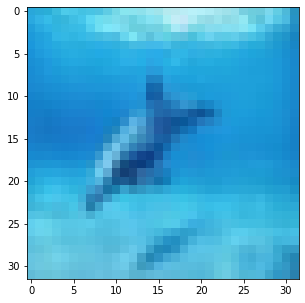

In [15]:
plt.figure(figsize = (5, 5))
plt.imshow(cifar_test_no_prep[index][0].permute(1, 2, 0))

In [16]:
def hook(module, input, output):
    print(torch.nn.functional.softmax(output, dim=1))

In [17]:
handle = model.input_layer.gate.register_forward_hook(hook)
model(cifar_test[index][0].unsqueeze(0).to(model.device))
handle.remove()


tensor([[0.2500, 0.2500, 0.2500, 0.2500]])


[22 18 11 30  6 17 33 48 55]


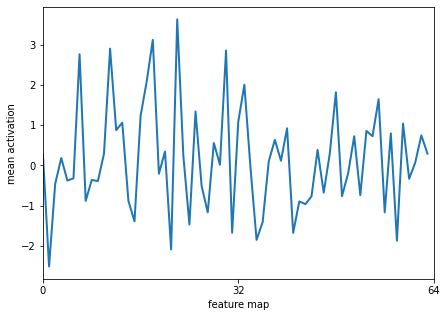

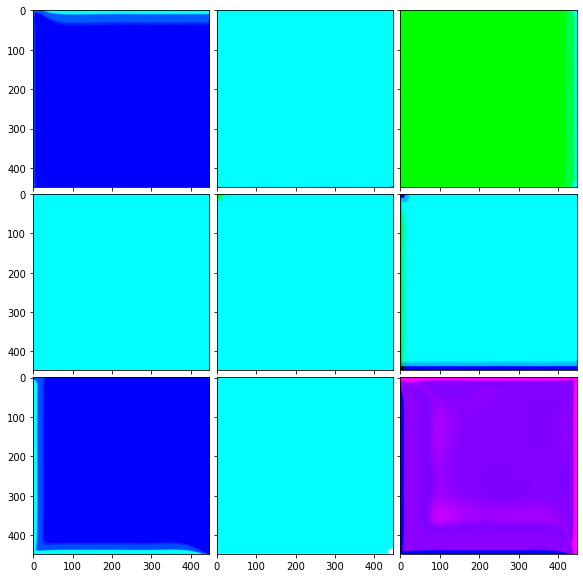

In [21]:
expert = 3

av1 = CNNActivationVisualization(model, moe_layer.experts[expert].model[1])
top_activations = av1.compute_activations(cifar_test[index][0].unsqueeze(0), number_of_filters=64, top_k=9)
print(top_activations)

from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,  #
                 nrows_ncols=(3, 3),  
                 axes_pad=0.1,  
                 )
images = []
for filter in top_activations:
    moe_layer.gate = EqualWeightGatingNetwork(64, 4)
    lc1 = CNNLayerVisualization(model, moe_layer.experts[expert].model[1], selected_filter=filter, mean=[0.5071, 0.4865, 0.4409], std=[0.2009, 0.1984, 0.2023])
    img = lc1.visualise_layer_with_hooks(init_size=8, scaling_factor=1.2, scaling_steps=25)
    images.append(img)

for ax, im in zip(grid, images):
    ax.imshow(im)

plt.show()
